# A very simple Emergency Department model, with limited resources and patient prioritisation

Here we look at a simple ED model, but we use limited resoucres (doctors) and prioritise patients, so that patients are seen by priority (and bu first-in-first-served within a priority band). We will also constrcut a custom Patient type. This construct allows us to store any specific information we want about a patient, allowing the simulation to use patient information in the simulation logic. We will store patient prority and patient pathway times, in this custom type.

A scematic of this very simple Emergency Department is shown below:

![](./images/ed_1.png)

The key coding steps, for a particualr process, in a prioritised resource model are:
* `resource = Resource(env, number)`: Set up resource type and max available. Associate with a specific environment (env).
* `@yield request(resource,priority=priority)`: request resources. The function will be held here until resources become available.
* `@yield timeout(env, time)`: time that resources will remain occupied
* `@yield release(resource)`: make resources available again.


Please see https://benlauwens.github.io/SimJulia.jl/stable/tutorial.html for a basic introduction to SimJulia.

## Set up project environment and load packages

If required, set up local project environment with `] instantiate` (looks for .toml files in the same directory), and import packages. Alternatively this could be achieved with:

```
using Pkg
Pkg.add("PyPlot")
Pkg.add("SimJulia")
Pkg.add("Distributions")
Pkg.add("DataFrames")
```

In [1]:
] instantiate

In [2]:
#using StatsBase
using PyPlot
using ResumableFunctions
using SimJulia
using Random, Distributions
using DataFrames

## Set up global variables

These variables will be accessed (and updated in some cases) using the `@global` prefix in functions.

In [3]:
# All times are in minutes

# SIMULATION CONTROL VARIABLES
# ============================

# Simulation run time (we omit a simulation warm-up time for simplicity)
sim_duration = 10000

# Average time between patients arriving
inter_arrival_time = 10

# Number of doctors in ED
number_of_docs = 2

# Time between audits
audit_interval = 100

# Average time patients spends being *treated* in ED
appointment_time_mean = 18
appointment_time_sd = 9

# TRACKING VARIABLES These variables are updated during the simulation run
# ========================================================================

# Docs currently in use
docs_in_use = 0

# Vectors used to store audit results
audit_time = []
audit_patients_waiting = []
audit_patients_waiting_p1 = []
audit_patients_waiting_p2 = []
audit_patients_waiting_p3 = []
audit_reources_used = []

# Proportion of patients in priorities 1,2,3
priority_dist = [0.3, 0.3, 0.4]

# Set up counter for number of a ptients entering simulation
patient_count = 0

# Set up running counts of patients waiting (total and by priority)
patients_waiting = 0
patients_waiting_by_priority = [0, 0, 0]

# Set up vector for patient metrics
patient_record = []

Any[]

## Set up Patient type

Our custom Patit type will hold:

* uid: Unique patient ID 
* priority: Priority 1-3 (1=highest)
* consulation_time: Time needed with doc
* queuing_time: Record time spent queing
* time_in: Record time arrival
* time_see_doc: Record time see doc
* time_out: Record exit time

We create this as a `struct` and using the prefix `mutable` allows for attribute values to be changed within the simulation.

In [4]:
mutable struct Patient
    #=
    Patient type
    =#
    
    uid # Unique patient ID 
    priority # Priority 1-3 (1=highest)
    consulation_time # Time needed with doc
    queuing_time # Record time spent queing
    time_in # Record time arrival
    time_see_doc # Record time see doc
    time_out # Record exit time
end

Define a function to create a new patient. 

In [5]:
function patient_init(env)
    #=
    Create new patient. 
    =#
    
    # Set references to global parameters
    global patient_count
    global priority_dist
    global appointment_time_mean
    global appointment_time_sd
    
    # Increment patient count
    patient_count += 1
    uid = patient_count
    
    # Sample priority
    cum_probs = cumsum(priority_dist)
    rand_num = rand()
    if rand_num <= cum_probs[1]
        p_priority = 1
    elseif rand_num <= cum_probs[2]
        p_priority = 2
    else
        p_priority = 3
    end
    
    #= Sample Sample time (assume log normal distribution). Note: log parameters
    are estimates from mean and sd. In a real sim fit σ & μ directly to data =#
    m = appointment_time_mean
    s = appointment_time_sd
    
    σ_log = s/m * 0.85
    μ_log = log(m) - σ_log^2/2
    d = LogNormal(μ_log, σ_log)
    consult_time = rand(d)
    
    # Set inital times (these will be updated in sim)
    queuing_time = 0 
    time_in = now(env)
    time_see_doc = 0
    time_out = 0    
    
    # Create and return patient
    patient = Patient(uid, p_priority, consult_time, queuing_time, time_in,
        time_see_doc, time_out)
    
    return patient

end      

patient_init (generic function with 1 method)

## Generating new arrivals (process)

This process (resumable) function is a continuous loop that creates new patients and passess them to the patient pathway. A `@yield timeout(time)` call is used to introduce a delay, between new patients, in the loop. The inter-arrival time between patients is sampled from an exponential distribution.

In [6]:
@resumable function new_admission(env)
    
    #=
    Continuous loop of new arrivals:
    1) Sample interval until next arrival from exponential distribution
    2) Wait for required interval
    3) Call a new patient process
    =#
    
    # Set references to global parameters
    global inter_arrival_time    
    
    while true
        # Get time to next patient arrival from exponential distribution
        next_p = rand(Exponential(inter_arrival_time))
        # Wait for next patient arrival
        @yield timeout(env, next_p)
        # Generate patient
        patient = patient_init(env)
        # Call patient pathway process
        @process patient_pathway(env, patient, doc)
    end
end

new_admission (generic function with 1 method)

## Patient pathway (process)

This process (resumable) function describes the patient journey. It requests resources (and the time those resources are allocated depend on the priority of the patient; doctors will always see the highest priority patients first).

Here we have just a single process step with a single resource type (doctor). 

In [7]:
@resumable function patient_pathway(env::Environment, patient::Patient, 
        doc::Resource)
    
    # Set references to global parameters
    global patient_queue
    global patients_waiting
    global patients_waiting_by_priority
    global patient_record
    global docs_in_use
    
    # Increment patient counts
    patients_waiting += 1
    patients_waiting_by_priority[patient.priority] += 1
    
    # Request resources
    @yield request(doc, priority=patient.priority)
    # Got resource, adjust trackers
    docs_in_use += 1
    patients_waiting -= 1
    patients_waiting_by_priority[patient.priority] -= 1
    patient.time_see_doc = now(env)
    patient.queuing_time = patient.time_see_doc - patient.time_in
    # Time with doc
    @yield timeout(env, patient.consulation_time)
    # Release doc,  adjust trackers
    @yield release(doc)
    docs_in_use -= 1
    patient.time_out = now(env)
    # Transfer all of info from Patient struct to global patient_record vector
    patient_info = [patient.uid, patient.priority, patient.consulation_time,
        patient.queuing_time, patient.time_in, patient.time_see_doc,
        patient.time_out]
    push!(patient_record, patient_info)    
    
end


patient_pathway (generic function with 1 method)

## Audit function (process)

The audit function is run at intervals (in a continuous `while` loop using `@yield timeout` for a fixed delay between audits. The function pushes the following to global trackers:

* audit_time: Time of audit (minutes from start)
* audit_patients_waiting: Total patients waiting to see doc
* audit_patients_waiting_p1: Priority 1 patients waiting to see doc
* audit_patients_waiting_p2: Priority 2 patients waiting to see doc
* audit_patients_waiting_p3: Priority 3 patients waiting to see doc
* audit_reources_used: Number of docs in use

In [8]:
@resumable function run_audit(env::Environment)
    
    global audit_time
    global audit_patients_waiting
    global audit_patients_waiting_p1
    global audit_patients_waiting_p2
    global audit_patients_waiting_p3
    global audit_reources_used
    global audit_interval
    global docs_in_use
    
    while true        
        # Add current state to trackers
        push!(audit_time, now(env))
        push!(audit_patients_waiting, patients_waiting)
        push!(audit_patients_waiting_p1, patients_waiting_by_priority[1])
        push!(audit_patients_waiting_p2, patients_waiting_by_priority[2])
        push!(audit_patients_waiting_p3, patients_waiting_by_priority[3])
        push!(audit_reources_used, docs_in_use)
        # Wait before next audit
        @yield timeout(env, audit_interval)
    end
end   

run_audit (generic function with 1 method)

## Main simulation run

The main simulatin run has the following steps:

* Set up SimJulia environment
* Set up resources
* Initalise processes
* Run Sim

In [9]:
# Set up simulation environment
env = Simulation()
# Set up resources
doc = Resource(env, number_of_docs)
# Set up starting processes (pass environment to process)
@process new_admission(env)
@process run_audit(env)
# Run simulation (pass simulation time)
run(env, sim_duration)

## Summarise results

Below we will summarise some key results using `DataFrames` and plot some key results using `PyPlot`.

### Summarise queuing times using DataFrames

We will summarise queuing times by priority using a DataFrame. The steps are:

* Convert vector of patient info into a matrx
* Create a DataFrame from the patient record matrix and list of column names
* Use `groupby` to create a vector of DataFrames by patient priority
* Use `combine` to store the mean, standard dev, and *n* for each priority. These are assigned to a new DataFrame.
* Sort summary table by priority

In [10]:
# Turn patient record vector in matrix
patient_record_matrix = transpose(reduce(hcat, patient_record))

# Create DataFrame from matrix
col_names = ["uid", "priority", "consulation_time", "queuing_time", "time_in", 
    "time_see_doc", "time_out"]
df = DataFrame(patient_record_matrix, col_names)

# Create separate DataFrames by priority, using groupy method
gdf = groupby(df, :priority)

# Combine summary results from grouped DataFrames
priority_group_summary = combine(gdf, 
    :queuing_time => mean => "Mean", 
    :queuing_time => std => "Std",
    :queuing_time => length => "n")

# Sort summary table
sort!(priority_group_summary, [:priority])

,priority,Mean,Std,n
,Float64,Float64,Float64,Int64
1,1.0,5.52495,6.12653,292
2,2.0,12.4895,16.0624,297
3,3.0,56.0003,89.4478,387


### Plot patients waiting and waiting time by priority

Here we use PyPlot (almost identical in syntax to Pythons MatPlotLib) to plot queues over time, and to show a violin (distribution) plot of waiting times for each patient priority group. We refer back to the DataFrame just created to get queuing times for each priority, using an array comprehension construct.

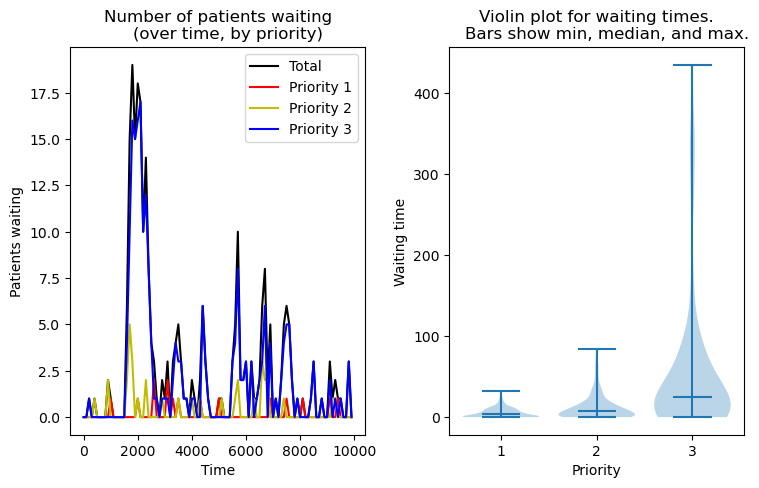

In [11]:
# Set up overall figure
fig, axs = plt.subplots(1, 2, figsize=(8,5))
fig.tight_layout(pad=3)
# Plot queues over time
axs[1].plot(audit_time, audit_patients_waiting, label="Total", color="k")
axs[1].plot(audit_time, audit_patients_waiting_p1, label="Priority 1", color="r")
axs[1].plot(audit_time, audit_patients_waiting_p2, label="Priority 2", color="y")
axs[1].plot(audit_time, audit_patients_waiting_p3, label="Priority 3", color="b")
axs[1].legend()
axs[1].set_xlabel("Time")
axs[1].set_ylabel("Patients waiting")
axs[1].set_title("Number of patients waiting
    (over time, by priority)")
# Violin plot of queuing time distributions
# Get queuing time for each priority (use vector comprehension)
samples = [df.queuing_time[df.priority.==i, :] for i in 1:3]
axs[2].violinplot(samples, showmedians=true, widths=0.8)
axs[2].set_xticks([1,2,3])
axs[2].set_xlabel("Priority")
axs[2].set_ylabel("Waiting time")
axs[2].set_title("Violin plot for waiting times.
    Bars show min, median, and max.")
# Display plot
plt.show()